<a href="https://colab.research.google.com/github/Yanis52/Skin-Cancer-Detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kagglehub


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from pathlib import Path
from google.colab import drive
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd
import seaborn as sns
import shutil
import os
from pathlib import Path
from sklearn.utils import class_weight


In [ ]:

drive.mount('/content/drive')
train_dir = Path("/content/drive/MyDrive/CBAM_project/augmented_data/Train")
test_dir = Path("/content/drive/MyDrive/CBAM_project/augmented_data/Test")



Mounted at /content/drive


In [ ]:
# dst_train = "/content/dataset/Train"
# dst_test = "/content/dataset/Test"

# if not os.path.exists(dst_test):
#     shutil.copytree(test_dir, dst_test)
#     print("✅ Données de test copiées.")

✅ Données de test copiées.


In [ ]:
dst_train = "/content/dataset/Train"
# dst_test = "/content/dataset/Test"

if not os.path.exists(dst_train):
    shutil.copytree(train_dir, dst_train)
    print("✅ Données de train copiées.")

✅ Données de train copiées.


**Définition du module CBAM**

In [ ]:
class AttentionBlock(tf.keras.layers.Layer):
    def __init__(self, filters, ratio=8, name="AttentionBlock", **kwargs):
        super().__init__(name=name, **kwargs)
        self.filters = filters
        self.ratio = ratio

    def build(self, input_shape):
        initializer = tf.keras.initializers.HeNormal()

        # Channel-wise attention
        self.avg_pool = layers.GlobalAveragePooling2D()
        self.max_pool = layers.GlobalMaxPooling2D()
        self.mlp = tf.keras.Sequential([
            layers.Dense(self.filters // (self.ratio*2), activation='relu', use_bias=False, kernel_initializer=initializer),
            layers.Dropout(0.2),
            layers.Dense(self.filters // self.ratio, activation='relu', use_bias=False, kernel_initializer=initializer),
            layers.Dropout(0.2),
            layers.Dense(self.filters, activation='sigmoid', use_bias=False, kernel_initializer=initializer)
        ])

        # Spatial attention block
        self.spatial = tf.keras.Sequential([
            layers.Conv2D(1, kernel_size=5, strides=1, padding='same', activation='sigmoid')

        ])



    def call(self, inputs,training=False):
        # Channel attention
        avg_out = self.avg_pool(inputs)
        max_out = self.max_pool(inputs)
        avg_weight = self.mlp(avg_out)
        max_weight = self.mlp(max_out)
        scale = tf.nn.sigmoid(avg_weight + max_weight)
        scale = tf.reshape(scale, [-1, 1, 1, self.filters])
        x = inputs * scale


        # Spatial attention
        avg_map = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_map = tf.reduce_max(x, axis=-1, keepdims=True)
        combined = tf.concat([avg_map, max_map], axis=-1)
        attn_map = self.spatial(combined)

        return x * attn_map


Construction du **modèle**

In [ ]:
def build_cbam_model(input_shape=(128, 128, 3), num_classes=9):
    inputs = tf.keras.Input(shape=input_shape)
    x = layers.Rescaling(1./255)(inputs)

    for i, filters in enumerate([64, 128, 256, 512]):
        x = layers.Conv2D(filters, 3, padding="same", use_bias=False, name=f"conv_{i}")(x)
        x = layers.BatchNormalization(name=f"bn_{i}")(x)
        x = layers.LeakyReLU(name=f"leakyrelu_{i}")(x)
        x = AttentionBlock(filters, name=f"cbam_block_{i}")(x)
        x = layers.MaxPooling2D(name=f"maxpool_{i}")(x)

    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(512)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax', name="output")(x)

    return tf.keras.Model(inputs, outputs, name="CBAM_Model")


Chargement du dataset depuis les images augmentées

In [ ]:
# img_height = 128
# img_width = 128
# batch_size = 32
# num_classes = 9



# train_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     train_dir,
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size
# )

# val_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     test_dir,
#     seed=123,
#     image_size=(img_height, img_width),
#     batch_size=batch_size
# )


In [ ]:
# split avec tensorflow

In [ ]:
img_height = 128
img_width = 128
batch_size = 32
num_classes = 9

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)
class_names = train_ds.class_names

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    validation_split=0.2,
    subset="validation",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 54000 files belonging to 9 classes.
Found 10800 files belonging to 9 classes.


In [ ]:
train_labels = []
for images, labels in train_ds:
    train_labels.extend(labels.numpy())

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Dictionnaire format {classe: poids}
class_weights = dict(enumerate(class_weights))

compilation

In [ ]:
model = build_cbam_model(input_shape=(img_height, img_width, 3), num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "CBAM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_0 (Conv2D)                 │ (None, 128, 128, 64)   │         1,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_0 (BatchNormalization)       │ (None, 128, 128, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leakyrelu_0 (LeakyReLU)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_block_0 (AttentionBlock)   │ (None, 128, 128, 64)   │           851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_0 (MaxPooling2D)        │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 64, 64, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 64, 64, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leakyrelu_1 (LeakyReLU)         │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_block_1 (AttentionBlock)   │ (None, 64, 64, 128)    │         3,251 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 32, 32, 256)    │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 32, 32, 256)    │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leakyrelu_2 (LeakyReLU)         │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_block_2 (AttentionBlock)   │ (None, 32, 32, 256)    │        12,851 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 16, 16, 512)    │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 16, 16, 512)    │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leakyrelu_3 (LeakyReLU)         │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_block_3 (AttentionBlock)   │ (None, 16, 16, 512)    │        51,251 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_3 (MaxPooling2D)        │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_4 (Conv2D)                 │ (None, 8, 8, 1024)     │     4,718,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 8, 8, 1024)     │         4,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leakyrelu_4 (LeakyReLU)         │ (None, 8, 8, 1024)     │             

 Total params: 27,305,115 (104.16 MB)

 Trainable params: 27,297,051 (104.13 MB)

 Non-trainable params: 8,064 (31.50 KB)

callbacks

In [ ]:
checkpoint_path = "/content/drive/MyDrive/CBAM_project/models/model6.keras"
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    # tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
]


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks,
    class_weight=class_weights
)


Epoch 1/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 199s 69ms/step - accuracy: 0.4554 - loss: 1.4636 - val_accuracy: 0.5465 - val_loss: 1.5258 - learning_rate: 1.0000e-04
Epoch 2/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 120s 42ms/step - accuracy: 0.6661 - loss: 0.8736 - val_accuracy: 0.4535 - val_loss: 2.0738 - learning_rate: 1.0000e-04
Epoch 3/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 112s 42ms/step - accuracy: 0.7759 - loss: 0.5894 - val_accuracy: 0.4406 - val_loss: 2.7839 - learning_rate: 1.0000e-04
Epoch 4/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 113s 43ms/step - accuracy: 0.8357 - loss: 0.4250 - val_accuracy: 0.5599 - val_loss: 2.3095 - learning_rate: 1.0000e-04
Epoch 5/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 113s 42ms/step - accuracy: 0.8753 - loss: 0.3277 - val_accuracy: 0.4848 - val_loss: 3.3442 - learning_rate: 1.0000e-04
Epoch 6/50
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 112s 42ms/step - accuracy: 0.8976 - loss: 0.2716 - val_accuracy: 0.5459 - val_loss: 2.0276 - learning_rate: 1.0000e-04
Epoch 7/50
1688/1688 ━━━━━━━━━━━━━

Évolution de la précision et de la perte par epoch

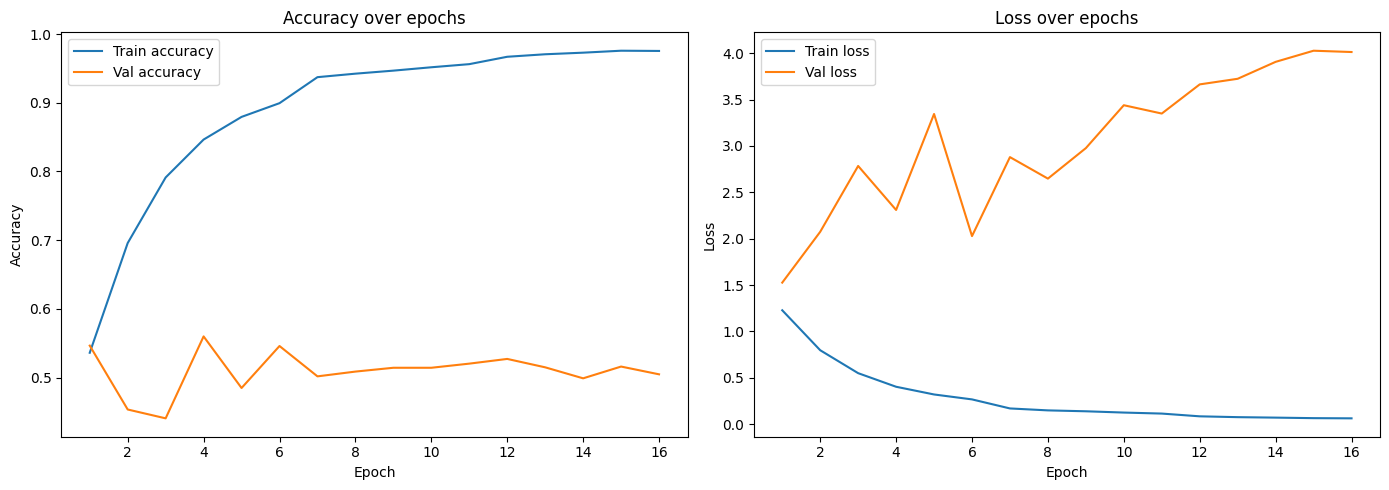

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train accuracy')
plt.plot(epochs, val_acc, label='Val accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train loss')
plt.plot(epochs, val_loss, label='Val loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


matrice de confusion

In [ ]:


y_true = []
y_pred = []

class_names = train_ds.class_names

for images, labels in val_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Matrice de confusion
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=90, cmap="Blues")
plt.title("Matrice de confusion")
plt.show()


AttributeError: '_PrefetchDataset' object has no attribute 'class_names'

 Distribution des prédictions (par classe)

In [ ]:


# Distribution des prédictions
df_pred = pd.DataFrame({'true': y_true, 'pred': y_pred})
df_pred['true_class'] = df_pred['true'].map(lambda i: class_names[i])
df_pred['pred_class'] = df_pred['pred'].map(lambda i: class_names[i])

plt.figure(figsize=(12, 5))
sns.countplot(x='pred_class', data=df_pred, order=class_names)
plt.title("Distribution des prédictions par classe")
plt.xticks(rotation=45)
plt.show()


Graphe des erreurs par classe

In [ ]:
# Pourcentage d'erreurs par classe
error_by_class = (df_pred['true'] != df_pred['pred']).groupby(df_pred['true_class']).mean()

error_by_class.plot(kind='bar', figsize=(10, 5), color='salmon')
plt.title("Taux d'erreur par classe")
plt.ylabel("Taux d'erreur")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()
